In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
# extract the pixel values
imgs = df.iloc[:, 1:].values

In [4]:
max_imgs = np.max(imgs)

In [5]:
ntot = imgs.shape[0]

In [6]:
# determine what's in the training set and the validation set
ntrain = np.floor(ntot * .6)
train_indices = np.random.randint(0, int(ntot), size = int(ntrain))

nvalid = ntot - ntrain
valid_indices = np.setdiff1d(list(range(0, ntot)), train_indices)

In [7]:
# create a ntrain * 28 * 28 ndarray of training set
cube = np.ndarray(shape = (ntot, 1, 28, 28), dtype = "float")

In [8]:
for i in range(0, ntot):
    cube[i, 0, :, :] = (imgs[i, :].reshape(28, 28)) / max_imgs

In [9]:
# Create a tensor containing the correct labels
labels = df.iloc[:, 0].values

In [10]:
labels

array([1, 0, 1, ..., 7, 6, 9])

In [11]:
# break data into training and validation sets
train_cube = torch.FloatTensor(cube[train_indices, :, :, :])
valid_cube = torch.FloatTensor(cube[valid_indices, :, :, :])

train_labels = torch.from_numpy(labels[train_indices])
valid_labels = torch.from_numpy(labels[valid_indices])

In [12]:
print(train_cube.size())
print(train_labels.size())
print(valid_cube.size())
print(valid_labels.size())

torch.Size([25200, 1, 28, 28])
torch.Size([25200])
torch.Size([23045, 1, 28, 28])
torch.Size([23045])


In [13]:
trainset = torch.utils.data.TensorDataset(train_cube, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, 
                                          shuffle = True, num_workers = 4)

testset = torch.utils.data.TensorDataset(valid_cube, valid_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, 
                                          shuffle = True, num_workers = 4)

In [14]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

  [1]   [7]   [6]   [1]   [9]   [5]   [5]   [0]   [7]   [1]   [1]   [4]   [8]   [2]   [4]   [5]


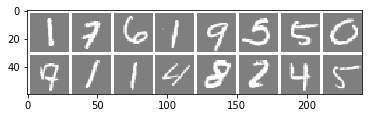

In [15]:
# show some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%labels.numpy()[j] for j in range(trainloader.batch_size)))

In [83]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv1_drop = nn.Dropout2d()
        self.conv2 = nn.Conv2d(20, 40, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(640, 80)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(80, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net

Net (
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv1_drop): Dropout2d (p=0.5)
  (conv2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (640 -> 80)
  (fc1_drop): Dropout (p = 0.5)
  (fc2): Linear (80 -> 10)
)

In [84]:
params = list(net.parameters())
print(len(params))
print(params[0].size())
print(params[2].size())
print(params[4].size())

8
torch.Size([20, 1, 5, 5])
torch.Size([40, 20, 5, 5])
torch.Size([80, 640])


In [85]:
optimizer = optim.Adam(net.parameters())

In [86]:
def train(epoch):
    net.train()
    for batch_index, (inputs, labels) in enumerate(trainloader):
        inputs, labels = Variable(inputs), Variable(torch.squeeze(labels))
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        if batch_index % 400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_index * len(inputs), len(trainloader.dataset),
                    100. * batch_index / len(trainloader), loss.data[0]))

In [87]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = Variable(data, volatile=True), Variable(torch.squeeze(target))
        output = net(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

In [88]:
for epoch in range(3): # loop over the dataset multiple times
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/25200 (0%)]	Loss: 2.308779
Train Epoch: 0 [6400/25200 (25%)]	Loss: 1.652806
Train Epoch: 0 [12800/25200 (51%)]	Loss: 0.422264
Train Epoch: 0 [19200/25200 (76%)]	Loss: 0.166836

Test set: Average loss: 0.1482, Accuracy: 21976/23045 (95%)

Train Epoch: 1 [0/25200 (0%)]	Loss: 0.231115
Train Epoch: 1 [6400/25200 (25%)]	Loss: 0.411312
Train Epoch: 1 [12800/25200 (51%)]	Loss: 0.145159
Train Epoch: 1 [19200/25200 (76%)]	Loss: 0.223805

Test set: Average loss: 0.0946, Accuracy: 22370/23045 (97%)

Train Epoch: 2 [0/25200 (0%)]	Loss: 0.317860
Train Epoch: 2 [6400/25200 (25%)]	Loss: 0.052327
Train Epoch: 2 [12800/25200 (51%)]	Loss: 0.202737
Train Epoch: 2 [19200/25200 (76%)]	Loss: 0.283724

Test set: Average loss: 0.0825, Accuracy: 22451/23045 (97%)

